In [ ]:
pip install elasticdeform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.7 MB/s 


In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import sys
import os
from tqdm import tqdm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization, LeakyReLU, Conv2DTranspose,Reshape
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator,random_rotation, random_shift,random_zoom,random_brightness, random_channel_shift, random_shear,load_img, img_to_array
import glob
import pathlib
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from mlxtend.plotting import plot_confusion_matrix
from google.colab import drive
from numpy import expand_dims
from PIL import Image
import elasticdeform, imageio
%matplotlib inline

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
!cd '../content/gdrive/MyDrive/CMPE_597_Project/597_project_dataset'
path = '/content/gdrive/MyDrive/CMPE_597_Project/597_project_dataset'
list(os.listdir(path))
list(os.listdir(path + "/Training"))
list(os.listdir(path + "/Testing"))
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

While implementing, the following notebooks are utilized:

https://www.kaggle.com/code/fahadmehfoooz/brain-tumor-detection-keras-pytorch

https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn/notebook

https://www.kaggle.com/code/rohandeysarkar/tumor-classification

https://www.kaggle.com/code/erkamk/brain-tumor-classification


In [ ]:
image_size = 200
sigma = 4
points = 3

**CONVERTING DATASET TO 1 CHANNEL**

Here, we combine test and training dataset on purpose. Then, we will split it to test and training after shuffling which increases randomness.

In [ ]:
# Çalıştırırsan deformed dataların olduğu dosyaları temizler
for label in labels:
  files = glob.glob('/content/gdrive/MyDrive/CMPE_597_Project/597_project_dataset/DeformedData/'+label +'/*.jpg')
  for f in files:
      os.remove(f)

In [ ]:
# from google.colab.patches import cv2_imshow
# image_size = 200
# sigma = 6
# points = 5

# img = cv2.imread(os.path.join(path,'Training/glioma_tumor/gg (1).jpg'))
# img = cv2.resize(img,(image_size, image_size))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = np.reshape(img, (image_size, image_size))
# deformed_img = elasticdeform.deform_random_grid(img, sigma=sigma, points=points)
# cv2_imshow(img)
# cv2_imshow(deformed_img)

In [ ]:
def create_X_y(folder):
  X = []
  y = []
  for i in labels:
    folderPath = os.path.join(path,folder,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if j.endswith(".jpg"):
          img = cv2.resize(img,(image_size,image_size))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          X.append(img)
          y.append(i)

  X = np.array(X)
  y = np.array(y)

  X, y = shuffle(X,y, random_state=101)

  y_new = []
  for i in y:
      y_new.append(labels.index(i))
  y = y_new
  y = tf.keras.utils.to_categorical(y)

  return X,y

In [ ]:
X_train = []
y_train = []
for i in labels:
    folderPath = os.path.join(path,'Training',i)
    deformedPath = os.path.join(path,'DeformedData',i)
    if not os.path.exists(deformedPath):
      os.makedirs(deformedPath)
    for j in tqdm(os.listdir(folderPath)):
        temp = deformedPath
        temp += f'/{j}'
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X_train.append(img)
        y_train.append(i)
        
        img = np.reshape(img, (image_size, image_size))
        deformed_img = elasticdeform.deform_random_grid(img, sigma=sigma, points=points)
        deformed_img = np.reshape(deformed_img, (image_size, image_size, 1))
        tf.keras.utils.save_img(temp, deformed_img)

        
for i in labels:
    folderPath = os.path.join(path,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X_train.append(img)
        y_train.append(i)

100%|██████████| 74/74 [00:00<00:00, 109.79it/s]


In [ ]:
# All images with 1D channel
X_train = np.array(X_train)
y_train = np.array(y_train)

print("Total Number of Images: ", len(X_train))

# Shuffling and splitting the data
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

# Converting text categorical labels to numerical and one hot encoded labels
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Total Number of Images:  3274


**DATA AUGMENTATION**

In [ ]:
# Çalıştırırsan augmented dataların olduğu dosyaları temizler
for label in labels:
  files = glob.glob('/content/gdrive/MyDrive/CMPE_597_Project/597_project_dataset/Augmented/'+label +'/*.jpg')
  for f in files:
      os.remove(f)

In [ ]:
# img = cv2.imread(path + "/Training/glioma_tumor/gg (2).jpg")
# img = cv2.resize(img,(200, 200))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img=np.reshape(img, (1,200,200,1))
# datagen = ImageDataGenerator( #bunun parametrelerini değiştir.
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.15,
#     shear_range=6,
#     brightness_range=[0.1,1.5],
#     fill_mode='constant',
#     horizontal_flip=True)
# # datagen = ImageDataGenerator(brightness_range=[0.1,1.5])
# it = datagen.flow(img, batch_size=1)

In [ ]:
# for i in range(9):
#   batch = it.next()
#   image = batch[0].astype('uint8')
#   image = np.reshape(image, (200,200))
#   plt.imshow(image, cmap = 'gray')
#   plt.show()

In [ ]:
def augmented_data_generator(label, increase_ratio):
  X_train = []
  path = '/content/gdrive/MyDrive/CMPE_597_Project/597_project_dataset/'
  train_path = path+'Training/' + label+'/'
  for j in tqdm(os.listdir(train_path)):
      img = cv2.imread(os.path.join(train_path,j))
      img = cv2.resize(img,(image_size, image_size))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      X_train.append(img)

  X_train = np.array(X_train)

  X_train = np.expand_dims(X_train, axis = -1)

  datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    shear_range=6,
    brightness_range=[0.1,1.5],
    fill_mode='constant',
    horizontal_flip=True)

  i = 0
  batch_size=1
  augmented_path = path + 'Augmented/' + label
  if not os.path.exists(augmented_path):
    os.makedirs(augmented_path)
  for batch in datagen.flow(X_train, batch_size=batch_size,  
                            save_to_dir=augmented_path, 
                            save_prefix='aug', 
                            save_format='jpg'):
      i += 1
      if i > increase_ratio*(X_train.shape[0]):
          break

In [ ]:
for label in labels:
  augmented_data_generator(label = label, increase_ratio = 0.5 if label == 'no_tumor' else 0.2)

100%|██████████| 827/827 [00:05<00:00, 151.71it/s]


In [ ]:
X_augmented, y_augmented = create_X_y("Augmented")

100%|██████████| 166/166 [00:00<00:00, 282.88it/s]


In [ ]:
split_ratio = 0.3
X_deformed, y_deformed = create_X_y("DeformedData")
X_deformed = X_deformed[0:int(X_deformed.shape[0]*split_ratio)]
y_deformed = y_deformed[0:int(y_deformed.shape[0]*split_ratio)]

100%|██████████| 827/827 [00:03<00:00, 275.18it/s]


In [ ]:
X_only_aug =  np.concatenate((X_train, X_augmented), axis = 0)
y_only_aug =  np.concatenate((y_train, y_augmented), axis = 0)
X_only_aug, y_only_aug = shuffle(X_only_aug, y_only_aug, random_state=101)

In [ ]:
X = np.concatenate((X_train, X_augmented, X_deformed), axis = 0)
y = np.concatenate((y_train, y_augmented, y_deformed), axis = 0)
X, y = shuffle(X, y, random_state=101)

**MODEL FOR ORIGINAL DATASET**

In [ ]:
model_plain = tf.keras.Sequential([
          Conv2D(kernel_size=(5,5) ,filters=32, activation='relu', padding='same', input_shape = (200,200, 1)),
          MaxPool2D(pool_size=(2,2)),

          Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
          MaxPool2D(pool_size=(2,2)),
          BatchNormalization(),

          Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same'),
          MaxPool2D(pool_size=(2,2)),

          Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'),
          MaxPool2D(pool_size=(2,2)),

          Flatten(),
          Dense(128, activation='relu'),
          Dropout(rate=0.5),
          Dense(4, activation='softmax')
  ])
model_plain.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], image_size, image_size, 1))
X = np.reshape(X, (X.shape[0], image_size, image_size, 1))

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience=3, verbose=1, mode = "max", restore_best_weights = True)

callbacks_list = [early_stop]

In [ ]:
history = model_plain.fit(X_train, y_train, epochs=20, batch_size=32, shuffle=True, validation_split = 0.1, callbacks=callbacks_list)

Epoch 1/20
83/83 [==============================] - 15s 39ms/step - loss: 1.1525 - accuracy: 0.5379 - val_loss: 1.1717 - val_accuracy: 0.4373
Epoch 2/20
83/83 [==============================] - 3s 31ms/step - loss: 0.6531 - accuracy: 0.7390 - val_loss: 0.7418 - val_accuracy: 0.7186
Epoch 3/20
83/83 [==============================] - 3s 31ms/step - loss: 0.4961 - accuracy: 0.8133 - val_loss: 0.6127 - val_accuracy: 0.7729
Epoch 4/20
83/83 [==============================] - 3s 31ms/step - loss: 0.3765 - accuracy: 0.8570 - val_loss: 0.4007 - val_accuracy: 0.8678
Epoch 5/20
83/83 [==============================] - 3s 32ms/step - loss: 0.3129 - accuracy: 0.8804 - val_loss: 0.3458 - val_accuracy: 0.8881
Epoch 6/20
83/83 [==============================] - 3s 31ms/step - loss: 0.2335 - accuracy: 0.9114 - val_loss: 0.3428 - val_accuracy: 0.8847
Epoch 7/20
83/83 [==============================] - 3s 31ms/step - loss: 0.2010 - accuracy: 0.9204 - val_loss: 0.3618 - val_accuracy: 0.8746
Epoch 8/20
8

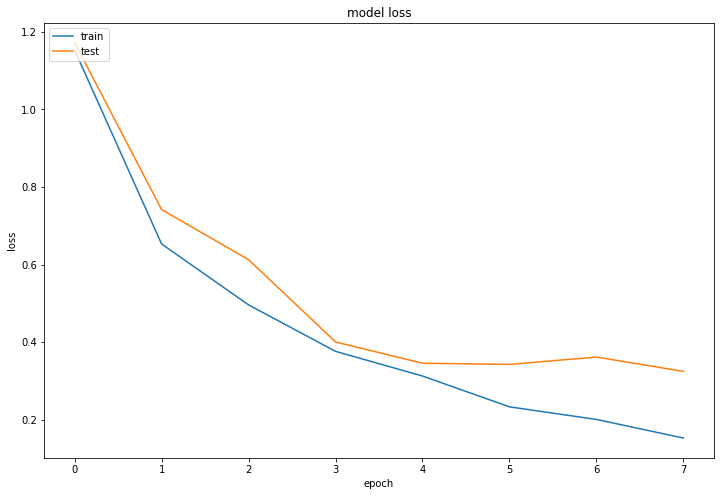

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

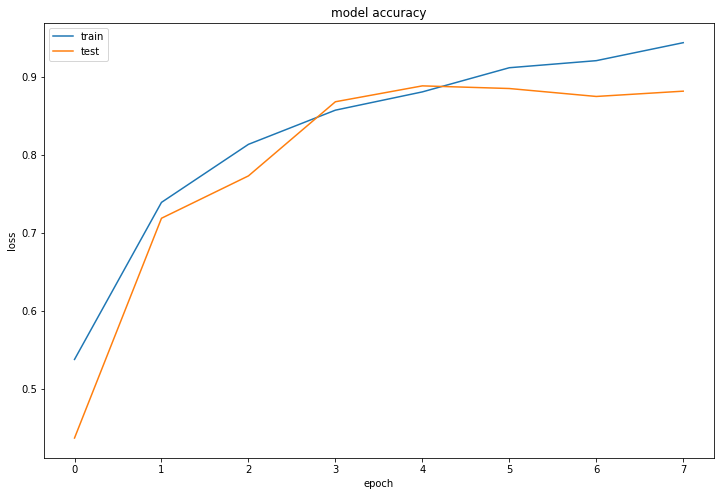

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#TESTING MODEL WITH ORIGINAL DATASET
pred_orig = model_plain.predict(X_test)
pred_orig = np.argmax(pred_orig,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new, pred_orig))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        97
           1       0.88      0.88      0.88        48
           2       0.93      0.85      0.89        94
           3       0.91      0.97      0.93        89

    accuracy                           0.91       328
   macro avg       0.91      0.91      0.91       328
weighted avg       0.92      0.91      0.91       328



**MODEL WITH ONLY AUGMENTED DATASET**

In [ ]:
model_augmented = tf.keras.Sequential([
          Conv2D(kernel_size=(5,5) ,filters=32, activation='relu', padding='same', input_shape = (200,200, 1)),
          MaxPool2D(pool_size=(2,2)),

          Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
          MaxPool2D(pool_size=(2,2)),
          BatchNormalization(),

          Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same'),
          MaxPool2D(pool_size=(2,2)),

          Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'),
          MaxPool2D(pool_size=(2,2)),

          Flatten(),
          Dense(128, activation='relu'),
          Dropout(rate=0.5),
          Dense(4, activation='softmax')
  ])
model_augmented.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model_augmented.fit(X, y, epochs=20, batch_size=32, shuffle=True, validation_split = 0.1, callbacks=callbacks_list)

Epoch 1/20
127/127 [==============================] - 5s 35ms/step - loss: 1.1612 - accuracy: 0.5274 - val_loss: 1.0813 - val_accuracy: 0.5366
Epoch 2/20
127/127 [==============================] - 4s 32ms/step - loss: 0.7712 - accuracy: 0.6889 - val_loss: 0.9134 - val_accuracy: 0.6630
Epoch 3/20
127/127 [==============================] - 4s 35ms/step - loss: 0.6396 - accuracy: 0.7532 - val_loss: 0.7998 - val_accuracy: 0.6608
Epoch 4/20
127/127 [==============================] - 5s 38ms/step - loss: 0.5021 - accuracy: 0.8018 - val_loss: 0.8054 - val_accuracy: 0.6741
Epoch 5/20
127/127 [==============================] - 5s 36ms/step - loss: 0.4336 - accuracy: 0.8284 - val_loss: 0.5666 - val_accuracy: 0.7805
Epoch 6/20
127/127 [==============================] - 4s 32ms/step - loss: 0.3659 - accuracy: 0.8587 - val_loss: 0.5152 - val_accuracy: 0.8204
Epoch 7/20
127/127 [==============================] - 4s 32ms/step - loss: 0.2888 - accuracy: 0.8893 - val_loss: 0.6947 - val_accuracy: 0.7539

In [ ]:
#TESTING MODEL WITH AUGMENTED DATASET
pred_aug = model_augmented.predict(X_test)
pred_aug = np.argmax(pred_aug,axis=1)
print(classification_report(y_test_new, pred_aug))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        97
           1       0.73      0.98      0.84        48
           2       0.93      0.66      0.77        94
           3       0.95      0.97      0.96        89

    accuracy                           0.87       328
   macro avg       0.86      0.88      0.86       328
weighted avg       0.88      0.87      0.87       328



**MODEL WITH COMPLETE AUGMENTED DATASET**

In [ ]:
model_complete = tf.keras.Sequential([
          Conv2D(kernel_size=(5,5) ,filters=32, activation='relu', padding='same', input_shape = (200,200, 1)),
          MaxPool2D(pool_size=(2,2)),

          Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
          MaxPool2D(pool_size=(2,2)),
          BatchNormalization(),

          Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same'),
          MaxPool2D(pool_size=(2,2)),

          Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'),
          MaxPool2D(pool_size=(2,2)),

          Flatten(),
          Dense(128, activation='relu'),
          Dropout(rate=0.5),
          Dense(4, activation='softmax')
  ])
model_complete.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_complete.fit(X, y, epochs=20, batch_size=32, shuffle=True, validation_split = 0.1, callbacks=callbacks_list)

Epoch 1/20
127/127 [==============================] - 5s 33ms/step - loss: 1.2273 - accuracy: 0.5160 - val_loss: 0.9609 - val_accuracy: 0.6098
Epoch 2/20
127/127 [==============================] - 4s 31ms/step - loss: 0.8169 - accuracy: 0.6595 - val_loss: 0.6475 - val_accuracy: 0.7251
Epoch 3/20
127/127 [==============================] - 4s 32ms/step - loss: 0.6576 - accuracy: 0.7394 - val_loss: 0.5623 - val_accuracy: 0.7916
Epoch 4/20
127/127 [==============================] - 4s 32ms/step - loss: 0.5478 - accuracy: 0.7784 - val_loss: 0.6355 - val_accuracy: 0.7339
Epoch 5/20
127/127 [==============================] - 4s 31ms/step - loss: 0.4576 - accuracy: 0.8171 - val_loss: 0.6170 - val_accuracy: 0.7494
Epoch 6/20
127/127 [==============================] - 4s 31ms/step - loss: 0.3991 - accuracy: 0.8442 - val_loss: 0.4064 - val_accuracy: 0.8381
Epoch 7/20
127/127 [==============================] - 4s 32ms/step - loss: 0.3355 - accuracy: 0.8676 - val_loss: 0.4339 - val_accuracy: 0.8404

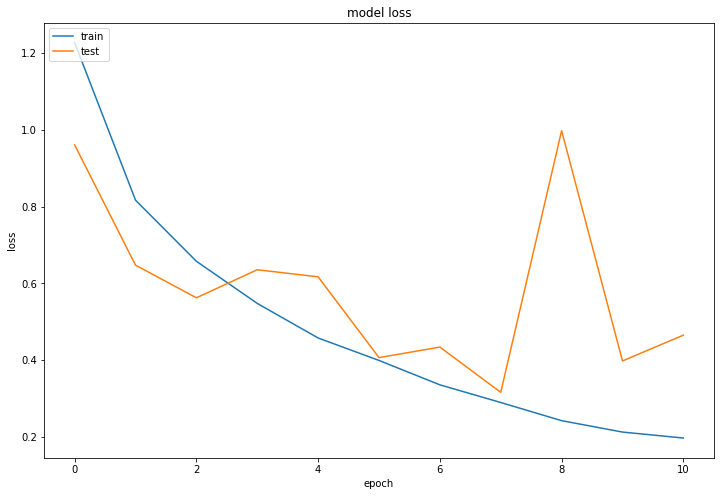

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

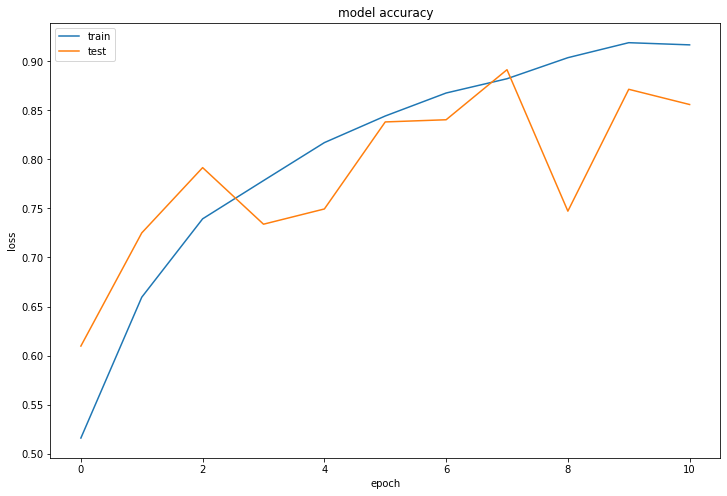

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#TESTING MODEL WITH COMPLETE DATASET
pred_aug = model_complete.predict(X_test)
pred_aug = np.argmax(pred_aug,axis=1)
print(classification_report(y_test_new, pred_aug))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        97
           1       0.85      0.96      0.90        48
           2       0.93      0.83      0.88        94
           3       0.98      0.97      0.97        89

    accuracy                           0.91       328
   macro avg       0.91      0.92      0.91       328
weighted avg       0.92      0.91      0.91       328



In [ ]:
history = list()

In [ ]:
def build_discriminator(in_shape=(200,200,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(32, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(16, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(8, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


def build_generator(latent_dim):
  model = Sequential()
  n_nodes = 200 * 25 * 25
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((25, 25, 200)))
  model.add(Conv2DTranspose(100, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(50, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(1, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  return model


def build_gan(gen_model, disc_model):
	disc_model.trainable = False
	model = Sequential()
	model.add(gen_model)
	model.add(disc_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y


def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


def generate_fake_samples(generator_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator_model.predict(x_input)
	y = np.zeros((n_samples, 1))
	return X, y
    
def train(generator_model, discriminator_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    #history = list()
    batch_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        tmp_hist = list()
        for j in range(batch_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = discriminator_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            tmp_hist.append(g_loss)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_epoch, d_loss, g_loss))
            
        history.append(np.mean(tmp_hist))
        if (i+1) % 10 == 0:
            filename = 'generator_model_%03d.h5' % (i + 1)
            generator_model.save(filename)
    #return history


In [ ]:
latent_dim = 256
discriminator_model = build_discriminator()
generator_model = build_generator(latent_dim)
gan_model = build_gan(generator_model, discriminator_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#history = train(generator_model, discriminator_model, gan_model, X_train, latent_dim, n_epochs= 100)
train(generator_model, discriminator_model, gan_model, X_train, latent_dim, n_epochs= 1000)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
>550, 8/11, d=0.364, g=2.115
>550, 9/11, d=0.336, g=1.682
>550, 10/11, d=0.395, g=2.273
>550, 11/11, d=0.423, g=1.657
>551, 1/11, d=0.297, g=2.141
>551, 2/11, d=0.355, g=2.152
>551, 3/11, d=0.342, g=1.939
>551, 4/11, d=0.392, g=1.958
>551, 5/11, d=0.472, g=2.278
>551, 6/11, d=0.403, g=1.742
>551, 7/11, d=0.430, g=2.141
>551, 8/11, d=0.373, g=2.279
>551, 9/11, d=0.358, g=1.686
>551, 10/11, d=0.456, g=2.429
>551, 11/11, d=0.376, g=1.917
>552, 1/11, d=0.394, g=1.782
>552, 2/11, d=0.370, g=1.720
>552, 3/11, d=0.370, g=2.512
>552, 4/11, d=0.480, g=1.363
>552, 5/11, d=0.418, g=1.731
>552, 6/11, d=0.344, g=2.277
>552, 7/11, d=0.370, g=2.099
>552, 8/11, d=0.413, g=1.904
>552, 9/11, d=0.320, g=2.046
>552, 10/11, d=0.375, g=2.188
>552, 11/11, d=0.351, g=1.772
>553, 1/11, d=0.400, g=2.003
>553, 2/11, d=0.400, g=2.126
>553, 3/11, d=0.345, g=1.978
>553, 4/11, d=0.412, g=2.101
>553, 5/11, d=0.425, g=2.040
>553, 6/11, d=0.370, g=2.207
>553, 7/11, d=0.349

In [ ]:
len(history[:100])

100

Text(0, 0.5, 'Loss')

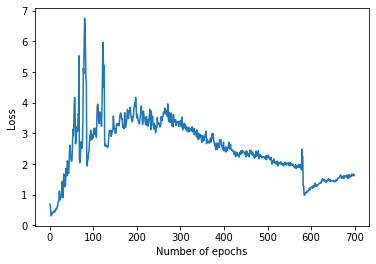

In [ ]:
plt.plot(history[:700], label='GAN loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

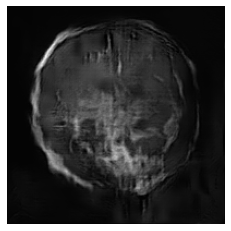

In [ ]:
from keras.models import load_model
#generator = load_model('generator_model_200.h5')
generator = generator_model
latent_dim = 256
n = 1

n_samples = n * n
np.random.seed(100)

rand_vec = np.random.randn(latent_dim * n_samples)
rand_vec = rand_vec.reshape(n_samples, latent_dim)
X = generator.predict(rand_vec)

plt.figure(figsize=((4, 4)))
for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap='gray')

plt.show()
plt.close()